In this exercise, we will try to implement YOLOv1

# Import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
import cv2
from collections import Counter
import random
from termcolor import colored


import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision import models
from torchvision.models.resnet import ResNet34_Weights


import albumentations as A
from albumentations.pytorch import ToTensorV2

# Data

## Create Dataset class of YOLO format

We will use VOC dataset. We first covert the dataset into YOLO format

In [2]:
def convert_to_yolo_format(target, class_mapping):
    """
    Convert the target bounding boxes to YOLO format.
    Parameters:
    targets (list): List of dictionaries containing target information.
    Each dictionary should have 'category_id' and 'bbox' keys.
    'bbox' should be a list of [x_min, y_min, width, height].
    img_width (int): Width of the image.
    img_height (int): Height of the image.
    class_mapping (dict): Mapping from category IDs to class indices.
    Returns:
    np.ndarray: Array of shape (N, 5) where N is the number of targets.
    """
    annotations = target['annotation']['object']

    real_width = int(target['annotation']['size']['width'])
    real_height = int(target['annotation']['size']['height'])

    bboxes = []

    if not isinstance(annotations, list):
        annotations = [annotations]

    for anno in annotations:
        # Extract bounding box coordinates and normalize them
        x_min = int(anno['bndbox']['xmin']) / real_width
        y_min = int(anno['bndbox']['ymin']) / real_height
        x_max = int(anno['bndbox']['xmax']) / real_width 
        y_max = int(anno['bndbox']['ymax']) / real_height 
        
        # Get the center coordinates and width/height relative to the image size
        # The values are normalized to [0, 1]
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min

        # Get the class ID from the mapping
        class_name = anno['name']
        class_id = class_mapping[class_name] if class_name in class_mapping else 0
        
        # YOLO format: [class_id, x_center, y_center, width, height]
        bboxes.append([class_id, x_center, y_center, width, height])

    return np.array(bboxes)

In [3]:
class CustomVOCDataset(torchvision.datasets.VOCDetection):
    def init_config_yolo(self, class_mapping, S=7, B=2, C=20, custom_transform=None):
        self.S = S
        self.B = B
        self.C = C
        self.class_mapping = class_mapping
        self.custom_transform = custom_transform

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        
        # Convert to yolo format
        boxes = convert_to_yolo_format(target, self.class_mapping)
        just_boxes = boxes[:, 1:]
        labels = boxes[:, 0]

        # Apply transformations if any
        if self.custom_transform:
            # The transformation requires a dictionary with keys 'image', 'bboxes', and 'labels'
            sample = {
                'image': np.array(img),
                'bboxes': just_boxes,
                'labels': labels
            }
            sample = self.custom_transform(**sample)
            img = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']

        # Create a label matrix
        label_matrix = torch.zeros((self.S, self.S, self.B * 5 + self.C))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        img = torch.as_tensor(img, dtype=torch.float32)

        for box, class_label in zip(boxes, labels):
            x, y, width, height = box.tolist()
            label = int(class_label)

            # Calculate the grid (i, j) that the center of the box falls into
            i, j = int(self.S * y), int(self.S * x)
            x_cell = self.S * x - j
            y_cell = self.S * y - i

            # Calculate the width and height of the box relative to the cell size
            width_cell = width * self.S
            height_cell = height * self.S

            # If no object has been detected in this cell, assign the box to it
            if label_matrix[i, j, 20] == 0:
                # Mark that an object is present in this cell
                label_matrix[i, j, 20] = 1

                # Assign the box coordinates and class label to the label matrix
                box_coords = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                label_matrix[i, j, 21:25] = box_coords
                label_matrix[i, j, label] = 1

        return img, label_matrix

# Calculating functions

## Define IOU and NMS

In [4]:
def intersection_over_union(boxes_pred, boxes_labels, box_format='midpoint'):
    """
    Calculate the Intersection over Union (IoU) between predicted and ground truth boxes.
    Parameters:
    boxes_pred (list): List of predicted boxes.
    Each box should be a list of [x_center, y_center, width, height].
    boxes_labels (list): List of ground truth boxes.
    Each box should be a list of [x_center, y_center, width, height].
    box_format (str): Format of the boxes ('midpoint' or 'corners').
    Returns:
    float: IoU value.
    """
    if box_format == 'midpoint':
        # Convert to corners format
        box1_x1 = boxes_pred[..., 0:1] - boxes_pred[..., 2:3] / 2
        box1_y1 = boxes_pred[..., 1:2] - boxes_pred[..., 3:4] / 2
        box1_x2 = boxes_pred[..., 0:1] + boxes_pred[..., 2:3] / 2
        box1_y2 = boxes_pred[..., 1:2] + boxes_pred[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == 'corners':
        box1_x1 = boxes_pred[..., 0:1]
        box1_y1 = boxes_pred[..., 1:2]
        box1_x2 = boxes_pred[..., 2:3]
        box1_y2 = boxes_pred[..., 3:4]

        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)


    # Compute the intersection area
    intersection_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Compute the area of both boxes
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection_area / (box1_area + box2_area - intersection_area + 1e-6)

In [5]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format='corner'):
    """Perform Non-Max Suppression on the bounding boxes.
    Parameters:
    bboxes (list): List of bounding boxes.
    Each box should be a list of [class_pred, prob_score, x1, y1, x2, y2].
    iou_threshold (float): IoU threshold for NMS.
    threshold (float): Confidence threshold.
    box_format (str): Format of the boxes ('midpoint' or 'corner').
    Returns:
    list: List of filtered bounding boxes after NMS.
    """
    assert type(bboxes) == list
    if len(bboxes) == 0:
        return []

    # Filter out boxes with low confidence scores
    bboxes = [box for box in bboxes if box[1] >= threshold]

    # Sort the boxes by confidence score in descending order
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    filtered_bboxes = []

    while len(bboxes) > 0:
        # Take the box with the highest confidence score
        chosen_box = bboxes.pop(0)
        filtered_bboxes.append(chosen_box)

        # Remove boxes that have a high IoU with the chosen box
        bboxes = [box for box in bboxes
                  if box[0] != chosen_box[0] or
                  intersection_over_union(torch.tensor(chosen_box[2:]), torch.tensor(box[2:]), box_format) < iou_threshold]

    return filtered_bboxes

## Define mAP

In [6]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculate the mean average precision (mAP).

    Parameters:
        pred_boxes (list): A list containing predicted bounding boxes with each box defined as [train_idx, class_prediction, prob_score, x1, y1, x2, y2].
        true_boxes (list): Similar to pred_boxes but containing information about true boxes.
        iou_threshold (float): IoU threshold, where predicted boxes are considered correct.
        box_format (str): "midpoint" or "corners" used to specify the format of the boxes.
        num_classes (int): Number of classes.

    Returns:
        float: The mAP value across all classes with a specific IoU threshold.
    """

    # List to store mAP for each class
    average_precisions = []

    # Small epsilon to stabilize division
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Iterate through all predictions and targets, and only add those belonging to
        # the current class 'c'.
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Find the number of boxes for each training example.
        # The Counter here counts the number of target boxes we have
        # for each training example, so if image 0 has 3, and image 1 has 5,
        # we'll have a dictionary like:
        # amount_bboxes = {0: 3, 1: 5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then loop through each key, val in this dictionary and convert it to the following (for the same example):
        # amount_bboxes = {0: torch.tensor([0, 0, 0]), 1: torch.tensor([0, 0, 0, 0, 0])}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sort by box probability, index 2 is the probability
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If there are no ground truth boxes for this class, it can be safely skipped
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only consider ground truth boxes with the same training index as the prediction
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # Only detect ground truth once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # True positive and mark this bounding box as seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # If IOU is lower, the detection result is false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # Use torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

# Modeling

## YOLOv1 Model class

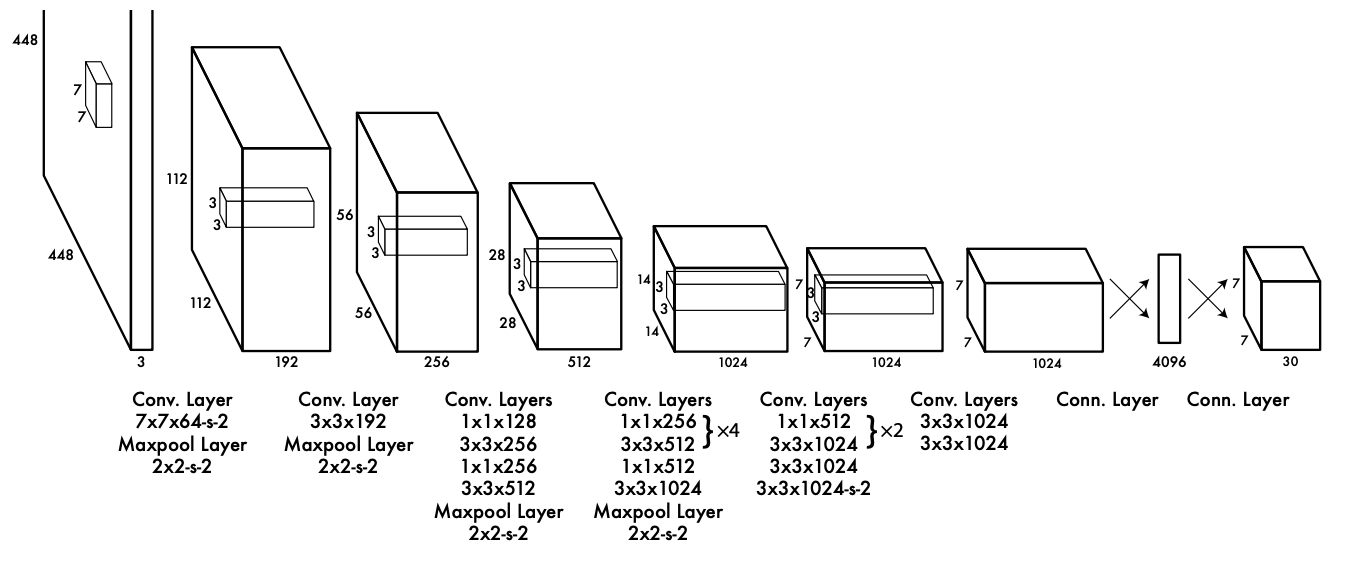

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))
    
class YOLOv1(nn.Module):
    def __init__(self, in_channels = 3, **kwargs):
        super(YOLOv1, self).__init__()
        self.in_channels = in_channels

        self.backbone = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        self.fcs = self._create_fcs(**kwargs)
    
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 14 * 14, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5))
        )
    
    def forward(self, x):
        x = self.backbone(x)
        return self.fcs(torch.flatten(x, start_dim=1))

## YOLO loss

In [8]:
class YOLOLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = 0.5
        self.lambda_noobj = 5

    def forward(self, predictions, target):
        # Reshape predictions to (batch_size, S, S, C + B*5)
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        
        # Calculate IoU for the predicted boxes and target boxes
        iou1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        iou = torch.cat((iou1.unsqueeze(0), iou2.unsqueeze(0)), dim=0)
        # Get the box with the highest IOU 
        # Note that the bestbox will have an index of 0 or 1, indicating which box is the best one
        iou_maxes, bestbox = torch.max(iou, dim=0)
        exists_box = target[..., 20].unsqueeze(3) # This represetns Iobj_i in the paper
        
        # Calculate the loss for the coordinates of the boxes
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30] +
                (1 - bestbox) * predictions[..., 21:25]
            )
        )
        box_targets = exists_box * target[..., 21:25]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2)
        )

        # Calculate the loss for the confidence of the boxes
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21])
        )

        # Calculate the loss for the no-object confidence
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1) 
        )
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1) 
        )
        # Compute the classification loss
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
            torch.flatten(exists_box * target[..., :20], end_dim=-2) 
        )
        # Calculate the total loss
        total_loss = (
            self.lambda_coord * box_loss +
            object_loss +
            self.lambda_noobj * no_object_loss +
            class_loss
        )

        return total_loss

# Train the YOLOv1 model

## Settings

In [12]:
seed = 123
random.seed(seed)
torch.manual_seed(seed)

LEARNING_RATE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 75
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = 'yolo.pth.tar'

In [9]:
WIDTH = 448
HEIGHT = 448

def get_train_transform():
    return A.Compose([
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9),
        ], p=0.9),
        A.ToGray(p=0.01),
        A.HorizontalFlip(p=0.2),
        A.VerticalFlip(p=0.2),
        A.Resize(width=WIDTH, height=HEIGHT, p=1.0),
        ToTensorV2(p=1.0)],
        p = 1.0,
        bbox_params=A.BboxParams(format='yolo', min_area=0.0, min_visibility=0, label_fields=['labels'])
    )

def get_valid_transform():
    return A.Compose([
        A.Resize(width=WIDTH, height=HEIGHT, p=1.0),
        ToTensorV2(p=1.0)],
        p = 1.0,
        bbox_params=A.BboxParams(format='yolo', min_area=0.0, min_visibility=0, label_fields=['labels'])
    )

In [10]:
class_mapping = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

## Other functions

In [11]:
# Function to convert cell-based boxes to format [x_center, y_center, width, height]
def convert_cellboxes(predictions, S=7):
    """
    Convert output boxes from YOLO with grid size S to image scale,
    instead of grid scale. This implementation uses loops for readability,
    as vectorized approaches can be less readable.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes


def get_bboxes_training(
    outputs,
    labels,
    iou_threshold=0.5,
    threshold=0.4,
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # Ensure the model is in evaluation mode before obtaining bounding boxes
    train_idx = 0

    true_bboxes = cellboxes_to_boxes(labels)
    bboxes = cellboxes_to_boxes(outputs)

    for idx in range(outputs.shape[0]):
        nms_boxes = non_max_suppression(
            bboxes[idx],
            iou_threshold=iou_threshold,
            threshold=threshold,
            box_format=box_format,
        )

        for nms_box in nms_boxes:
            all_pred_boxes.append([train_idx] + nms_box)

        for box in true_bboxes[idx]:
            # Convert multiple boxes to 0 if predicted
            if box[1] > threshold:
                all_true_boxes.append([train_idx] + box)

        train_idx += 1

    return all_pred_boxes, all_true_boxes

# Function to save model and optimizer state to a checkpoint file
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


# Function to load model and optimizer state from a saved checkpoint
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## Training functions

In [13]:
def train_fn(train_loader, model, optimizer, loss_fn, epoch):
    mean_loss = []
    mean_mAP = []

    total_batches = len(train_loader)
    display_interval = total_batches // 5

    for batch_idx, (x,y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Normalize the loss by the number of batches
        normalized_loss = loss / x.size(0)

        mean_loss.append(normalized_loss.item())

        if (batch_idx + 1)% display_interval == 0 or (batch_idx + 1) == total_batches:
            print(
                f"Epoch: {epoch:3} \t Iter: {batch_idx + 1:3}/{total_batches:3} \t Loss: {normalized_loss.item():.10f}"
            )
    mean_loss = sum(mean_loss) / len(mean_loss)
    print(colored(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {mean_loss:.4f}", 'green'))
    return mean_loss

In [14]:
def test_fn(test_loader, model, loss_fn, epoch, is_test=False): 
    model.eval()
    mean_loss = []
    mean_mAP = []

    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(test_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out, y)

            pred_boxes, true_boxes = get_bboxes_training(
                out, y, iou_threshold=0.5, threshold=0.5, box_format="midpoint", device=DEVICE
            )
            mAP = mean_average_precision(
                pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
            )
            #Normalize the loss by the number of batches
            normalized_loss = loss / x.size(0)

            mean_loss.append(normalized_loss.item())
            mean_mAP.append(mAP.item())

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)
    if is_test:
        print(colored(f"Epoch [{epoch+1}/{EPOCHS}] Test Loss: {avg_loss:.4f} mAP: {avg_mAP:.4f}", 'yellow'))
    else:
        print(colored(f"Epoch [{epoch+1}/{EPOCHS}] Validation Loss: {avg_loss:.4f} mAP: {avg_mAP:.4f}", 'blue'))
    model.train()
    return avg_mAP

## Load model

In [15]:
def initialize_model():
    """Initialize the model, optimizer, and loss function."""
    model = YOLOv1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = YOLOLoss()
    return model, optimizer, loss_fn


def load_model_checkpoint(model, optimizer):
    """Load model checkpoint if LOAD_MODEL is True."""
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
        print(colored(f"Loaded checkpoint from {LOAD_MODEL_FILE}", "cyan"))

def save_best_checkpoint(model, optimizer, filename=LOAD_MODEL_FILE):
    """Save the model checkpoint."""
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=filename)
    print(colored(f"Checkpoint saved to {filename}", "cyan"))


## Get dataloaders

In [16]:
from torch.utils.data import ConcatDataset


def prepare_data():
    """Prepare datasets and create data loaders for training, validation and testing."""
    # Prepare training dataset
    train_dataset = CustomVOCDataset(
        root="./data",
        year="2012",
        image_set="train",
        download=False,
    )
    train_dataset.init_config_yolo(
        class_mapping=class_mapping, custom_transform=get_train_transform()
    )

    # Prepare validation dataset
    val_dataset = CustomVOCDataset(
        root="./data",
        year="2012",
        image_set="val",
        download=False,
    )
    val_dataset.init_config_yolo(
        class_mapping=class_mapping, custom_transform=get_valid_transform()
    )

    # Combine datasets
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    total_size = len(combined_dataset)

    # Calculate split sizes (7:2:1 ratio)
    train_size = int(0.7 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    # Generate indices for splits
    indices = list(range(total_size))
    np.random.shuffle(indices)

    train_indices = indices[:train_size]
    val_indices = indices[train_size : train_size + val_size]
    test_indices = indices[train_size + val_size :]

    # Create samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    # Create data loaders
    train_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=False,
    )

    val_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        sampler=val_sampler,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=BATCH_SIZE,
        sampler=test_sampler,
        drop_last=False,
    )

    return (
        train_loader,
        val_loader,
        test_loader,
        combined_dataset,
        len(train_indices),
        len(val_indices),
        len(test_indices),
    )

def initialize_train_mAP_loader(train_dataset):
    """Initialize DataLoader for training mAP calculation."""
    train_mAP_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=SubsetRandomSampler(list(range(len(train_dataset)))),
        drop_last=False,
    )
    return train_mAP_loader

## Main training

In [17]:
def train():
    """Main training function orchestrating the training process."""
    # Initialize model, optimizer, and loss function
    model, optimizer, loss_fn = initialize_model()

    # Prepare datasets
    (
        train_loader,
        val_loader,
        test_loader,
        train_dataset,
        num_train,
        num_val,
        num_test,
    ) = prepare_data()

    # Log dataset statistics

    # Initialize variables to track best mAP
    best_mAP_val = 0
    best_mAP_test = 0

    # Initialize DataLoader for training mAP calculation
    train_mAP_loader = initialize_train_mAP_loader(train_dataset)

    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print(colored(f"\nStarting Epoch {epoch}/{EPOCHS}", "magenta"))

        # Training for one epoch
        avg_train_loss = train_fn(train_loader, model, optimizer, loss_fn, epoch)

        # Perform Validation and Testing every 5 epochs
        if epoch % 5 == 0:
            # Validation
            print(colored(f"\nValidation at Epoch {epoch}", "magenta"))
            val_mAP = test_fn(val_loader, model, loss_fn, epoch, is_test=False)
            train_mAP = test_fn(
                train_mAP_loader, model, loss_fn, epoch, is_test=False
            )
            print(colored(f"Train mAP during Validation: {train_mAP:.10f}", "green"))
            print(colored(f"Validation mAP: {val_mAP:.10f}", "blue"))

            # Update best validation mAP
            if val_mAP > best_mAP_val:
                best_mAP_val = val_mAP
                save_best_checkpoint(model, optimizer)
                print(colored(f"New best Val mAP: {best_mAP_val:.10f}", "blue"))

            # Testing
            print(colored(f"\nTesting at Epoch {epoch}", "magenta"))
            test_mAP = test_fn(test_loader, model, loss_fn, epoch, is_test=True)

            # Update best test mAP
            if test_mAP > best_mAP_test:
                best_mAP_test = test_mAP
                print(colored(f"New best Test mAP: {best_mAP_test:.10f}", "yellow"))

    # Training completion message
    print(colored("\nTraining Completed!", "magenta"))
    print(colored(f"Best Val mAP: {best_mAP_val:.10f}", "blue"))
    print(colored(f"Best Test mAP: {best_mAP_test:.10f}", "yellow"))


In [18]:
train()


Starting Epoch 1/75
Epoch:   1 	 Iter:  25/127 	 Loss: 12.8638000488
Epoch:   1 	 Iter:  50/127 	 Loss: 8.0325155258
Epoch:   1 	 Iter:  75/127 	 Loss: 6.1700849533
Epoch:   1 	 Iter: 100/127 	 Loss: 5.0870752335
Epoch:   1 	 Iter: 125/127 	 Loss: 5.9702954292
Epoch:   1 	 Iter: 127/127 	 Loss: 5.4892058372
Epoch [2/75] Train Loss: 43.8230

Starting Epoch 2/75
Epoch:   2 	 Iter:  25/127 	 Loss: 5.5148630142
Epoch:   2 	 Iter:  50/127 	 Loss: 6.4330472946
Epoch:   2 	 Iter:  75/127 	 Loss: 5.5176153183
Epoch:   2 	 Iter: 100/127 	 Loss: 5.5753774643
Epoch:   2 	 Iter: 125/127 	 Loss: 5.8052744865
Epoch:   2 	 Iter: 127/127 	 Loss: 8.2359790802
Epoch [3/75] Train Loss: 5.9010

Starting Epoch 3/75
Epoch:   3 	 Iter:  25/127 	 Loss: 5.6128864288
Epoch:   3 	 Iter:  50/127 	 Loss: 5.1109800339
Epoch:   3 	 Iter:  75/127 	 Loss: 4.5379223824
Epoch:   3 	 Iter: 100/127 	 Loss: 5.3051776886
Epoch:   3 	 Iter: 125/127 	 Loss: 4.7595767975
Epoch:   3 	 Iter: 127/127 	 Loss: 4.8933839798
Epoch [

C:\Users\admin\AppData\Local\Temp\ipykernel_10580\4065456467.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  im = np.array(image)


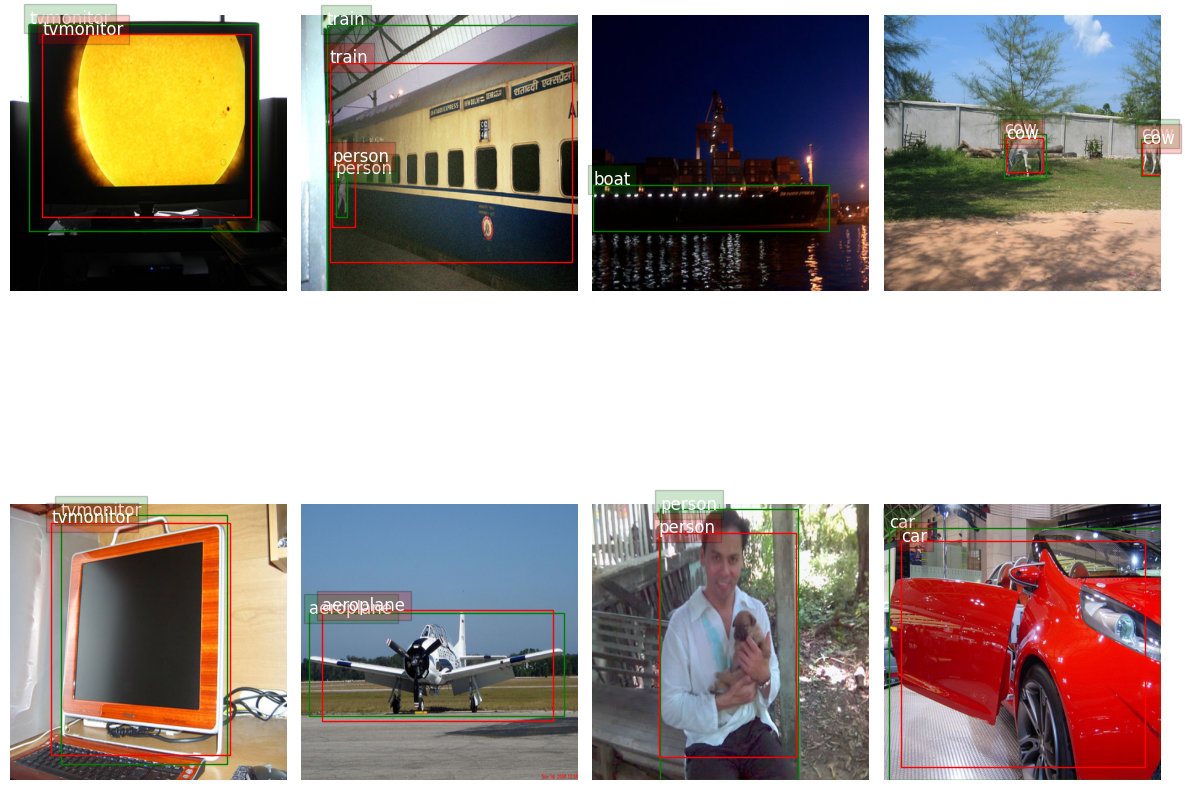

In [21]:
import matplotlib.patches as patches

LOAD_MODEL = True


def plot_image_with_labels(
    image, ground_truth_boxes, predicted_boxes, class_mapping, ax=None
):
    """Draw both ground truth and predicted bounding boxes on an image, with labels."""

    # Inverting the class mapping for easy access of class names based on indices
    inverted_class_mapping = {v: k for k, v in class_mapping.items()}

    # Convert the image to a numpy array and get its dimensions
    im = np.array(image)
    height, width, _ = im.shape

    ax.axis("off")
    ax.imshow(im)

    # Plot each ground truth box in green
    for box in ground_truth_boxes:
        # Extract label index and bounding box coordinates
        label_index, box = box[0], box[2:]
        # Calculate upper left coordinates
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        # Create a rectangle patch
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="green",
            facecolor="none",
        )
        # Add the rectangle to the plot
        ax.add_patch(rect)
        # Retrieve the class name and add it as text to the plot
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            class_name,
            color="white",
            fontsize=12,
            bbox=dict(facecolor="green", alpha=0.2),
        )

    # Plot each predicted box in red
    for box in predicted_boxes:
        # Similar processing as for ground truth boxes
        label_index, box = box[0], box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
        class_name = inverted_class_mapping.get(label_index, "Unknown")
        ax.text(
            upper_left_x * width,
            upper_left_y * height,
            class_name,
            color="white",
            fontsize=12,
            bbox=dict(facecolor="red", alpha=0.2),
        )

    return ax


def test():
    # Create a YOLO model object with specific hyperparameters.
    model = YOLOv1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)

    # Load saved model weights and optimizer information from a file, if applicable.
    if LOAD_MODEL:
        model.load_state_dict(torch.load(LOAD_MODEL_FILE)["state_dict"])

    # Prepare the test dataset and DataLoader for model evaluation
    test_dataset = CustomVOCDataset(root="./data", image_set="val", download=False)
    test_dataset.init_config_yolo(
        class_mapping=class_mapping, custom_transform=get_valid_transform()
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
    )

    model.eval()
    # Iterate over the test dataset and process each batch
    for x, y in test_loader:
        x = x.to(DEVICE)
        out = model(x)

        # Convert model output to bounding boxes and apply non-max suppression
        pred_bboxes = cellboxes_to_boxes(out)
        gt_bboxes = cellboxes_to_boxes(y)

        fig, axes = plt.subplots(2, 4, figsize=(12, 12))
        axes = axes.flatten()

        # Plot the first 8 images with their ground truth and predicted bounding boxes
        for idx in range(8):
            pred_box = non_max_suppression(
                pred_bboxes[idx],
                iou_threshold=0.5,
                threshold=0.4,
                box_format="midpoint",
            )
            gt_box = non_max_suppression(
                gt_bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint"
            )

            image = x[idx].permute(1, 2, 0).to("cpu") / 255
            ax_image = plot_image_with_labels(
                image, gt_box, pred_box, class_mapping, ax=axes[idx]
            )

        plt.tight_layout()
        plt.show()

        break  # Stop after processing the first batch


test()
